# 3. Field of 8 inclined boreholes with straight trajectories : (a) Comparison with Eksilson's $g$-functions and pygfunction
The model is used to evaluate the $g$-functions of the "optimal" configuration of 8 inclined boreholes presented by Eskilson [1]. The $g$-functions evaluated using the model are compared to the $g$-functions of Eskilson and to the $g$-functions evaluated using pygfunction.

[1] P. Eskilson, Thermal analysis of heat extraction boreholes, Ph.D. thesis, University of Lund (1987).

In [1]:
# Import necessary packages
# Import packages for pygfunction
import pygfunction as gt
import numpy as np

# Import packages for geothermax
import geothermax as gm
from jax import numpy as jnp

# Import packages for visualization
from matplotlib import pyplot as plt
import pandas as pd

## 3(a).1. Eskilson's $g$-functions
Eskilson's $g$-functions are extracted from the thesis (Notes on Heat Transfer 4 - 1986, Figure 38).

In [2]:
data_Eskilson = np.loadtxt('Eskilson-optimal.txt')
lntts_Eskilson = data_Eskilson[:, 0]
gfunc_Eskilson = data_Eskilson[:, 1:]

## 3(a).2. Evaluation of $g$-functions using pygfunction
pygfunction is used to evaluate the delta-circuit thermal resistances of the boreholes using the multipole method. The $g$-functions are evaluated for boreholes at a $20\degree$ inclination and at spacing-to-length ratios $B/L=0.025,0.05,0.10$. For a better comparison of heat extraction rate and borehole wall temperature profiles, a uniform discretization of 24 segments is used to evaluate the $g$-functions (instead of the default non-uniform deiscretization of 8 segments).

### 3(a).2.1. Simulation parameters

In [3]:
# Borehole dimensions
D = 2.0             # Borehole buried depth (m)
L = 150.0           # Borehole length (m)
r_b = 0.075         # Borehole radius (m)
# Borehole spacings (m), tilt (deg), and inclinations (deg)
B = L * np.array([0.025, 0.05, 0.10])
tilt = np.radians(20.)
orientation = np.radians([180., 135., -135., 90., -90., 45., -45, 0.])

# Pipe dimensions
r_out = 0.0211      # Pipe outer radius (m)
r_in = 0.0147       # Pipe inner radius (m)
D_s = 0.052         # Shank spacing (m)
epsilon = 2.12e-5   # Pipe roughness (m)

# Pipe positions
# Single U-tube : [(x_in, y_in), (x_out, y_out)]
pos_pipes = [(-D_s, 0.), (D_s, 0.)]

# Ground properties
alpha = 1.0e-6      # Ground thermal diffusivity (m2/s)
k_s = 2.0           # Ground thermal conductivity (W/m.K)

# Grout properties
k_b = 1.0           # Grout thermal conductivity (W/m.K)

# Pipe properties
k_p = 0.4           # Pipe thermal conductivity (W/m.K)

# Fluid properties
m_flow_borehole = 0.375 # Total fluid mass flow rate per borehole (kg/s)
# The fluid is propylene-glycol (20 %) at 20 degC
cp_f = 3976.8       # Fluid specific heat capacity (in J/kg-K)
rho_f = 1014.8      # Fluid density (kg/m3)
mu_f = 2.0301e-3    # Fluid dynamic viscosity (kg/m.s)
k_f = 0.49221       # Fluid thermal conductivity (W/m.K)

The 'profile' option is set to `True` to allow a comparison of temperature and heat extraction rate profiles.

In [4]:
# g-Function calculation options
nSegments = 24
options = {'nSegments': nSegments,
           'segment_ratios': gt.utilities.segment_ratios(nSegments),
           'disp': False,
           'profiles': True}

# Uniform logarithmic time step from ln(t/t_s) = -5 to 5
Nt = 51                    # Number of time steps
ts = L**2 / (9 * alpha)    # Bore field characteristic time
lntts = np.linspace(-5., 5., num=Nt)
time = np.exp(lntts) * ts

The fluid-to-outer-pipe-wall thermal resistances are evaluated from fluid flow relations and conduction heat transfer through the pipe wall.

In [5]:
# Pipe thermal resistance
R_p = gt.pipes.conduction_thermal_resistance_circular_pipe(
    r_in, r_out, k_p)
# Fluid to inner pipe wall thermal resistance (Single U-tube)
m_flow_pipe = m_flow_borehole
h_f = gt.pipes.convective_heat_transfer_coefficient_circular_pipe(
    m_flow_pipe, r_in, mu_f, rho_f, k_f, cp_f, epsilon)
R_f = 1.0 / (h_f * 2 * np.pi * r_in)

### 3(a).2.2. Initialization of the `Network` objects
In pygfunction, borefields are represented as a list of `Borehole` objects.

In [6]:
borefields_pygfunction = []
nBoreholes = len(orientation)
for _B in B:
    borefields_pygfunction.append(
        [gt.boreholes.Borehole(L, D, r_b, _B * i, 0., tilt=tilt, orientation=_orientation)
         for i, _orientation in enumerate(orientation)]
    )

`Network` objects are then instantiated from a borefield and the single U-tube geometries of the boreholes.

In [7]:
# Single U-tube, same for all boreholes in the bore field
networks_pygfunction = []
for borefield in borefields_pygfunction:
    UTubes = []
    for borehole in borefield:
        SingleUTube = gt.pipes.SingleUTube(
            pos_pipes, r_in, r_out, borehole, k_s, k_b, R_f + R_p)
        UTubes.append(SingleUTube)
    m_flow_network = m_flow_borehole * nBoreholes
    networks_pygfunction.append(
        gt.networks.Network(borefield, UTubes, m_flow_network=m_flow_network, cp_f=cp_f)
    )

### 3(a).2.3. $g$-Functions
$g$-Functions are evaluated using the 'similarities' method.

In [8]:
pygfunc = [
    gt.gfunction.gFunction(
        network, alpha, time=time,
        boundary_condition='MIFT', options=options, method='similarities')
    for network in networks_pygfunction
    ]

## 3(a).3. Evaluation of $g$-functions using geothermax

### 3(a).3.1. Simulation parameters
For comparison, 3 segments of 11 nodes (33 nodes in total) are used the evaluate the $g$-functions.

In [9]:
N = 11    # Number of nodes per segment
S = 3     # Number of segments

### 3(a).3.2. Initialization of the Borefield objects
In geothermax, the `Network` objects are instantiated directly from a list of `Borehole` objects (which include information about the thermal resistances).

In [10]:
basis = gm.Basis.Legendre(N)
p_pipes = jnp.asarray(pos_pipes)
ground_heat_exchanger = gm.UTubeHeatExchanger(
    p_pipes, r_in, r_out, r_b, k_s, k_b, k_p, mu_f, rho_f, k_f, cp_f, epsilon)
R_d = ground_heat_exchanger.thermal_resistances(m_flow_borehole)
borefields_geothermax = []
for network in networks_pygfunction:
    boreholes = []
    for borehole in network.b:
        boreholes.append(
            gm.SingleUTube.from_dimensions(
                R_d,
                borehole.H,
                borehole.D,
                borehole.r_b,
                borehole.x,
                borehole.y,
                basis,
                S,
                tilt=borehole.tilt,
                orientation=borehole.orientation))
    borefields_geothermax.append(gm.Network(boreholes))

The borefield with a spacing $B / L = 0.10$ is visualized.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


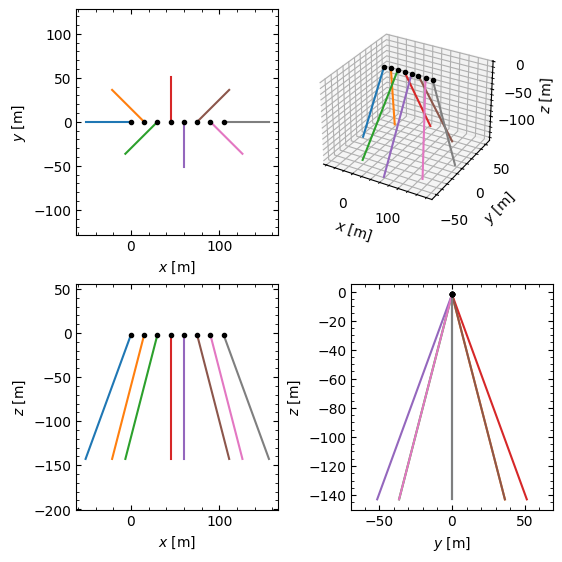

In [11]:
# Plot borefield
fig, axs = gm.utilities.plot_borefield(borefields_geothermax[-1]);
axs[1].set_position([0.55, 0.5, 0.35, 0.6], which='both')
fig.set_size_inches(140. / 25.4, 140. / 25.4)
fig.savefig('borefield-Eskilson-optimal.eps')

### 3(a).3.3. $g$-Functions
A `gFunction` object is instantiated for each borefield and the $g$-functions are evaluated.

In [12]:
gmgfunc = [gm.gFunction(borefield, m_flow_network, cp_f, time, alpha, k_s) for borefield in borefields_geothermax]
for gfunc in gmgfunc:
    gfunc.simulate()

Simulation start.
Completed 10 of 51 time steps. Elapsed time: 3.73 seconds.
Completed 20 of 51 time steps. Elapsed time: 6.87 seconds.
Completed 30 of 51 time steps. Elapsed time: 9.67 seconds.
Completed 40 of 51 time steps. Elapsed time: 12.84 seconds.
Completed 50 of 51 time steps. Elapsed time: 15.60 seconds.
Simulation end. Elapsed time: 15.60 seconds.
Simulation start.
Completed 10 of 51 time steps. Elapsed time: 0.08 seconds.
Completed 20 of 51 time steps. Elapsed time: 0.14 seconds.
Completed 30 of 51 time steps. Elapsed time: 0.21 seconds.
Completed 40 of 51 time steps. Elapsed time: 0.29 seconds.
Completed 50 of 51 time steps. Elapsed time: 0.36 seconds.
Simulation end. Elapsed time: 0.36 seconds.
Simulation start.
Completed 10 of 51 time steps. Elapsed time: 0.07 seconds.
Completed 20 of 51 time steps. Elapsed time: 0.14 seconds.
Completed 30 of 51 time steps. Elapsed time: 0.20 seconds.
Completed 40 of 51 time steps. Elapsed time: 0.27 seconds.
Completed 50 of 51 time steps

## 3(a).4. Comparison between $g$-functions

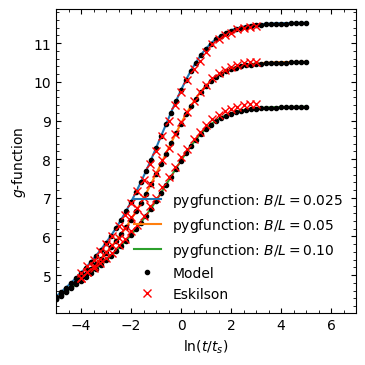

In [13]:
# Plot g-functions
fig, ax = plt.subplots(layout='constrained')
gm.utilities._format_axis(ax, axis_labels=[r'$\ln(t/t_s)$', r'$g$-function'])
for gfunc in pygfunc:
    ax.plot(np.log(time / ts), gfunc.gFunc);
ax.plot(jnp.log(time / ts), gmgfunc[0].g, 'k.');
ax.plot(lntts_Eskilson, gfunc_Eskilson[:, 0], 'rx');
for gfunc in gmgfunc[1:]:
    ax.plot(jnp.log(time / ts), gfunc.g, 'k.');
ax.plot(lntts_Eskilson, gfunc_Eskilson[:, 1:], 'rx');
ax.legend(
    [
        r'pygfunction: $B/L=0.025$',
        r'pygfunction: $B/L=0.05$',
        r'pygfunction: $B/L=0.10$',
        'Model',
        'Eskilson'
    ],
    frameon=False
);
fig.set_size_inches(90. / 25.4, 90. / 25.4)
ax.set_xlim(-5, 7)
fig.savefig('gFunction-Eskilson-optimal.eps')

The profiles of borehole wall temperature, heat extraction, and the time-variation of average borehole wall temperatures and heat extraction rates can also be visualized.

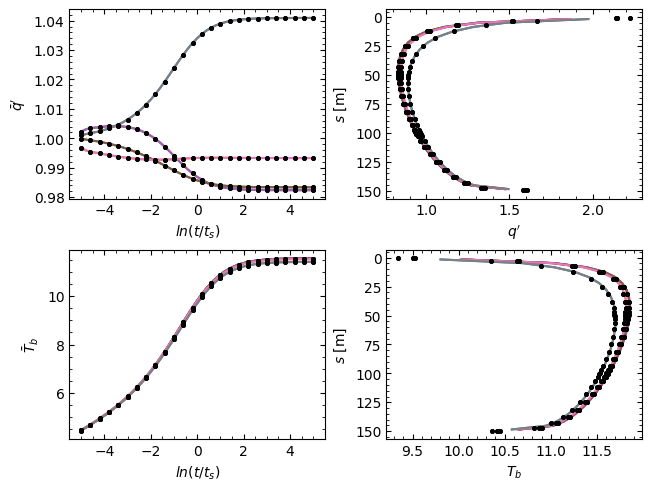

In [14]:
# Plot temperature and heat extraction rate profiles and time-variations
fig, axs = plt.subplots(nrows=2, ncols=2, layout='constrained')
axs = axs.flatten()
k = 0

lines = list(pygfunc[k].visualize_heat_extraction_rates().axes[1].get_lines());
plt.close()
axs[0] = gm.utilities._format_axis(axs[0], axis_labels=[r'$ln(t/t_s)$', r'$\bar{q}^\prime$'])
for line in lines:
    axs[0].plot(line.get_data()[0], line.get_data()[1])
q_avg = jnp.einsum('kjv,jv->kj', gmgfunc[k].q, borefields_geothermax[k].w) / borefields_geothermax[k].L / (2 * jnp.pi * k_s)
axs[0].plot(lntts, q_avg, 'k.', markevery=2);

lines = list(pygfunc[k].visualize_heat_extraction_rate_profiles().axes[1].get_lines());
plt.close()
axs[1] = gm.utilities._format_axis(axs[1], axis_labels=[r'$q^\prime$', r'$s$ [m]'], inverse_y=True)
for line in lines:
    axs[1].plot(line.get_data()[0], line.get_data()[1] - D)
axs[1].plot(gmgfunc[k].q[-1] / (2 * jnp.pi * k_s), borefields_geothermax[k].s, 'k.');

lines = list(pygfunc[k].visualize_temperatures().axes[1].get_lines());
plt.close()
axs[2] = gm.utilities._format_axis(axs[2], axis_labels=[r'$ln(t/t_s)$', r'$\bar{T}_b$'])
for line in lines:
    axs[2].plot(line.get_data()[0], line.get_data()[1])
T_b_avg = jnp.einsum('kjv,jv->kj', gmgfunc[k].T_b, borefields_geothermax[k].w) / borefields_geothermax[k].L
axs[2].plot(lntts, T_b_avg, 'k.', markevery=2);

lines = list(pygfunc[k].visualize_temperature_profiles().axes[1].get_lines());
plt.close()
axs[3] = gm.utilities._format_axis(axs[3], axis_labels=[r'$T_b$', r'$s$ [m]'], inverse_y=True)
for line in lines:
    axs[3].plot(line.get_data()[0], line.get_data()[1] - D)
axs[3].plot(gmgfunc[k].T_b[-1], borefields_geothermax[k].s, 'k.');